# Network activity

[The previous notebook](./2.1%20Anatomical%20embedding.ipynb) provided us with an anatomical reconstruction of the barrel cortex, defining locations of presynaptic cells, and post-synaptic targets onto our cell. Given this anatomical data, we can now activate the synapses according to experimental data.

To do this, we need the following information
 1. A parameter file specifying characteristics of the synaspses by celltype
 2. A parameterfile specifying the ongoing activity by celltype
 3. Parameterfiles specifying evoked response by stimulus, celltype and cell location

In [1]:
from pathlib import Path
tutorial_output_dir = f"{Path.home()}/isf_tutorial_output"  # <-- Change this to your desired output directory

In [2]:
import Interface as I
%matplotlib inline
db = I.DataBase(tutorial_output_dir)['network_modeling']

con_file = db['anatomical_constraints'].get_file('.con')
con_file_path = db['anatomical_constraints'].join(con_file)
syn_file = db['anatomical_constraints'].get_file('.syn')
syn_file_path = db['anatomical_constraints'].join(syn_file)

[INFO] ISF: Current version: heads/data+0.gebc00ec75.dirty
[INFO] ISF: Current pid: 102453
[INFO] ISF: Loading mechanisms:
[ATTENTION] ISF: The source folder has uncommited changes!



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 8.12.2, Interface: heads/data+0.gebc00ec75.dirty, PIL: 10.4.0, _brotli: 1.0.9, _csv: 1.0, _ctypes: 1.1.0, _curses: b'2.2', _decimal: 1.70, argparse: 1.1, backcall: 0.2.0, blosc: 1.11.1, bluepyopt: 1.9.126, brotli: 1.0.9, certifi: 2024.08.30, cffi: 1.17.0, charset_normalizer: 3.4.0, click: 7.1.2, cloudpickle: 3.1.0, colorama: 0.4.6, comm: 0.2.2, csv: 1.0, ctypes: 1.1.0, cycler: 0.12.1, cytoolz: 0.12.3, dash: 2.18.2, dask: 2.30.0, dateutil: 2.9.0, deap: 1.4, debugpy: 1.8.5, decimal: 1.70, decorator: 5.1.1, defusedxml: 0.7.1, distributed: 2.30.0, distutils: 3.8.20, django: 1.8.19, entrypoints: 0.4, executing: 2.1.0, fasteners: 0.17.3, flask: 1.1.4, fsspec: 2024.10.0, future: 1.0.0, greenlet: 3.1.1, idna: 3.10, ipaddress: 1.0, ipykernel: 6.2

## Characterizing ongoing activity

In [3]:
from getting_started import getting_started_dir
ongoing_template_param_name = I.os.path.join(
    getting_started_dir, 
    'example_data',
    'functional_constraints',
    'ongoing_activity',
    'ongoing_activity_celltype_template_exc_conductances_fitted.param')

In this parameter file, the following keys are defined

In [4]:
ongoing_template_param = I.scp.build_parameters(ongoing_template_param_name)
ongoing_template_param.keys()

dict_keys(['info', 'network', 'NMODL_mechanisms'])

The most relevant information is specified in the network key:

In [5]:
ongoing_template_param.network.keys()

dict_keys(['L2', 'L34', 'L4py', 'L4sp', 'L4ss', 'L5st', 'L5tt', 'L6cc', 'L6ccinv', 'L6ct', 'VPM', 'L1', 'L23Trans', 'L45Peak', 'L45Sym', 'L56Trans', 'SymLocal1', 'SymLocal2', 'SymLocal3', 'SymLocal4', 'SymLocal5', 'SymLocal6'])

Here, parameters are defined for each presynaptic celltype:

In [6]:
ongoing_template_param.network.L5tt

{'celltype': 'spiketrain',
 'interval': 283.3,
 'synapses': {'receptors': {'glutamate_syn': {'threshold': 0.0,
    'delay': 0.0,
    'parameter': {'tau1': 26.0,
     'tau2': 2.0,
     'tau3': 2.0,
     'tau4': 0.1,
     'decayampa': 1.0,
     'decaynmda': 1.0,
     'facilampa': 0.0,
     'facilnmda': 0.0},
    'weight': [1.59, 1.59]}},
  'releaseProb': 0.6}}

 - `interval`: mean ongoing interspike interval
 - `releaseProb`: chance that synapse gets activated if presynaptic cell gets activated
 - `synapses.receptors.glutamate_syn.parameter`: 
    - parameters for the NEURON mechanism defined in [mechanisms.channels](../../../mechanisms/l5pt/__init__.py)
      - `tau1`: NMDA decay time
      - `tau2`: NMDA rise time
      - `tau3`: AMPA decay time
      - `tau4`: AMPA rise time
 - `synapses.receptors.weight`
      - maximum conductance of the synapse for AMPA and NMDA, respectively

## Characterizing evoked activity

Evoked activity captures the network activity during a specific *in vivo* condition.
The experimental condition we will consider here is a passive whisker touch of the rat.
We have files capturing the activity of all celltypes in all locations across the rat barrel cortex.
Let's see what their activity was when we touched the whisker in arc C, row 2.

In [7]:
evokedPrefix = I.os.path.join(getting_started_dir, 'example_data/functional_constraints/evoked_activity/')
excitatory_PSTHs = [fname for fname in I.os.listdir(evokedPrefix) if fname.endswith('PSTH_UpState.param')]
inhibitory_PSTHs = [fname for fname in I.os.listdir(evokedPrefix) if fname.endswith('active_timing_normalized_PW_1.0_SuW_0.5.param')]

Let's have a look at a specific parameterfile:

In [8]:
excitatory_PSTHs

['L2_3x3_PSTH_UpState.param',
 'L34_3x3_PSTH_UpState.param',
 'L4py_3x3_PSTH_UpState.param',
 'L4sp_3x3_PSTH_UpState.param',
 'L4ss_3x3_PSTH_UpState.param',
 'L5st_3x3_PSTH_UpState.param',
 'L5tt_3x3_PSTH_UpState.param',
 'L6cc_3x3_PSTH_UpState.param',
 'L6ccinv_3x3_PSTH_UpState.param',
 'L6ct_3x3_PSTH_UpState.param']

In [9]:
example_PSTH_L6cc = I.scp.build_parameters(I.os.path.join(evokedPrefix, 'L6cc_3x3_PSTH_UpState.param'))
example_PSTH_L6cc.keys()

dict_keys(['L6cc_B1', 'L6cc_B2', 'L6cc_B3', 'L6cc_C1', 'L6cc_C2', 'L6cc_C3', 'L6cc_D1', 'L6cc_D2', 'L6cc_D3'])

We have entries for each column, each containing the respective evoked PSTH in a C2 stimulus scenario:

In [10]:
example_PSTH_L6cc

{'L6cc_B1': {'distribution': 'PSTH',
  'intervals': [(10.0, 11.0),
   (11.0, 12.0),
   (20.0, 21.0),
   (22.0, 23.0),
   (32.0, 33.0),
   (33.0, 34.0),
   (34.0, 35.0),
   (36.0, 37.0),
   (37.0, 38.0),
   (41.0, 42.0),
   (43.0, 44.0),
   (45.0, 46.0)],
  'probabilities': [0.0034,
   0.0034,
   0.0072,
   0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0034]},
 'L6cc_B2': {'distribution': 'PSTH',
  'intervals': [(10.0, 11.0),
   (17.0, 18.0),
   (20.0, 21.0),
   (25.0, 26.0),
   (34.0, 35.0),
   (36.0, 37.0),
   (37.0, 38.0),
   (41.0, 42.0)],
  'probabilities': [0.0034,
   0.0034,
   0.0072,
   0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0072]},
 'L6cc_B3': {'distribution': 'PSTH',
  'intervals': [(5.0, 6.0),
   (7.0, 8.0),
   (16.0, 17.0),
   (23.0, 24.0),
   (28.0, 29.0),
   (38.0, 39.0),
   (40.0, 41.0),
   (44.0, 45.0),
   (46.0, 47.0),
   (49.0, 50.0)],
  'probabilities': [0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0034,
   0.0034,


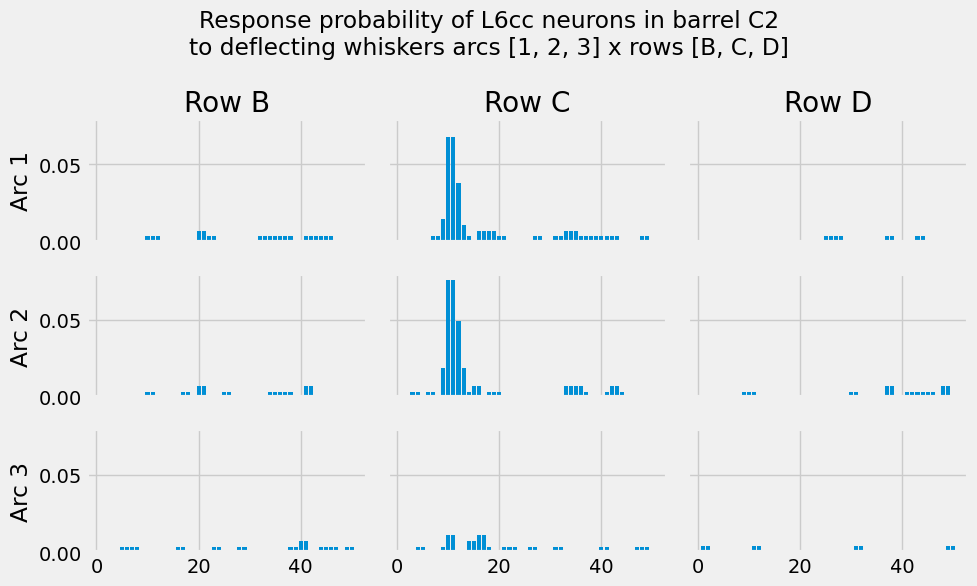

In [11]:
%matplotlib inline
I.plt.style.use("fivethirtyeight")
rows, cols = (1, 2, 3), ("B", "C", "D")
fig, axs = I.plt.subplots(len(rows), len(cols), sharey=True, sharex=True, figsize=(10, 6))

for cell_type, psth in example_PSTH_L6cc.items():
    p, bins = psth['probabilities'], psth['intervals']
    barrel_ind, layer = cell_type.split('_')[-1]
    ax_row_ind, ax_col_ind = rows.index(int(layer)), cols.index(barrel_ind)
    for b, p_ in zip(bins, p):
        axs[ax_row_ind, ax_col_ind].bar(b, p_, color="C0")
    if ax_col_ind == 0: axs[ax_row_ind, ax_col_ind].set_ylabel("Arc {}".format(rows[ax_row_ind]))
    if ax_row_ind == 0: axs[ax_row_ind, ax_col_ind].set_title("Row {}".format(cols[ax_col_ind]))

I.plt.suptitle("Response probability of L6cc neurons in barrel C2\nto deflecting whiskers arcs [1, 2, 3] x rows [B, C, D]")
fig.tight_layout()
I.plt.show()

## Combining ongoing and evoked activity into a network parameter file

Now, let's reverse-engineer our network parameters from this. Given that we know how a single cell population responds to various input stimuli, we can now generate activity data for all cell populations under a single stimulus. Note the subtle difference here. 
The previous histogram shows the response probability of the **same cell population** under **different whisker deflections**.
Below, we will generate activity data for **different cell populations** for the **same whisker deflection**.

To so, we use the [`create_evoked_network_parameter`](../../../singlecell_input_mapper/evoked_network_param_from_template.py) pipeline:

In [12]:
whisker = 'C2' 
# cell number spreadsheet generated in anatomical realization step.
cell_number_file_name = db['anatomical_constraints'].join('NumberOfConnectedCells.csv')
if not 'network_param' in db.keys(): db.create_managed_folder('network_param')
out_file_name = db['network_param'].join('C2_stim.param')

I.create_evoked_network_parameter(
    ongoing_template_param_name, 
    cell_number_file_name,
    syn_file_path, 
    con_file_path, 
    whisker, 
    out_file_name
)

*************
creating network parameter file from template /home/bgmeulem/Documents/in_silico_framework/getting_started/example_data/functional_constraints/ongoing_activity/ongoing_activity_celltype_template_exc_conductances_fitted.param
*************


Let's also generate parameterfiles for surround whisker stimuli!

In [13]:
with I.silence_stdout:
    for whisker in ['B1', 'B2', 'B3', 'C1', 'C3', 'D1', 'D2', 'D3']:
        I.create_evoked_network_parameter(
            ongoing_template_param_name, 
            cell_number_file_name, 
            syn_file_path, con_file_path, 
            whisker,
            db['network_param'].join('{}_stim.param'.format(whisker))
            )

The resulting network parameters describe ongoing and evoked activity for each synapse in a cell type specific manner. 


## Inspecting the network activity

Let's visualize the response probabilities of each cell type, similar to what we did above.

In [14]:
network_param_C2 = I.scp.build_parameters(db['network_param'].join('C2_stim.param'))
network_param_C2.network.keys()

dict_keys(['L2_Alpha', 'L2_B1', 'L2_B2', 'L2_B3', 'L2_B4', 'L2_Beta', 'L2_C1', 'L2_C2', 'L2_C3', 'L2_C4', 'L2_D1', 'L2_D2', 'L2_D3', 'L2_D4', 'L2_E1', 'L2_E2', 'L2_Gamma', 'L34_A1', 'L34_A2', 'L34_A3', 'L34_A4', 'L34_Alpha', 'L34_B1', 'L34_B2', 'L34_B3', 'L34_B4', 'L34_Beta', 'L34_C1', 'L34_C2', 'L34_C3', 'L34_C4', 'L34_D1', 'L34_D2', 'L34_D3', 'L34_Delta', 'L34_E1', 'L34_E2', 'L34_E3', 'L34_Gamma', 'L4py_A1', 'L4py_A2', 'L4py_A3', 'L4py_A4', 'L4py_Alpha', 'L4py_B1', 'L4py_B2', 'L4py_B3', 'L4py_B4', 'L4py_C1', 'L4py_C2', 'L4py_C3', 'L4py_C4', 'L4py_D1', 'L4py_D2', 'L4py_D3', 'L4py_Gamma', 'L4sp_B1', 'L4sp_B2', 'L4sp_B3', 'L4sp_Beta', 'L4sp_C1', 'L4sp_C2', 'L4sp_C3', 'L4sp_C4', 'L4sp_D1', 'L4sp_D2', 'L4sp_D3', 'L4sp_Delta', 'L4ss_A1', 'L4ss_B1', 'L4ss_B2', 'L4ss_B3', 'L4ss_C1', 'L4ss_C2', 'L4ss_C3', 'L4ss_D1', 'L4ss_D2', 'L4ss_D3', 'L4ss_E1', 'L5st_A1', 'L5st_A2', 'L5st_A3', 'L5st_Alpha', 'L5st_B1', 'L5st_B2', 'L5st_B3', 'L5st_B4', 'L5st_Beta', 'L5st_C1', 'L5st_C2', 'L5st_C3', 'L5st_C4'

In [27]:
surround_column_map = {
    'A1': {'Alpha': 4, 'A1': 5, 'A2': 6, 'B1': 8, 'B2': 9},\
    'A2': {'A1': 4, 'A2': 5, 'A3': 6, 'B1': 7, 'B2': 8, 'B3': 9},\
    'A3': {'A2': 4, 'A3': 5, 'A4': 6, 'B2': 7, 'B3': 8, 'B4': 9},\
    'A4': {'A3': 4, 'A4': 5, 'B3': 7, 'B4': 8},\
    'Alpha': {'Alpha': 5, 'A1': 6, 'Beta': 8, 'B1': 9},\
    'B1': {'Alpha': 1, 'A1': 2, 'A2': 3, 'Beta': 4, 'B1': 5, 'B2': 6, 'C1': 8, 'C2': 9},\
    'B2': {'A1': 1, 'A2': 2, 'A3': 3, 'B1': 4, 'B2': 5, 'B3': 6, 'C1': 7, 'C2': 8, 'C3': 9},\
    'B3': {'A2': 1, 'A3': 2, 'A4': 3, 'B2': 4, 'B3': 5, 'B4': 6, 'C2': 7, 'C3': 8, 'C4': 9},\
    'B4': {'A3': 1, 'A4': 2, 'B3': 4, 'B4': 5, 'C3': 7, 'C4': 8},\
    'Beta': {'Alpha': 2, 'Beta': 5, 'B1': 6, 'Gamma': 8, 'C1': 9},\
    'C1': {'Beta': 1, 'B1': 2, 'B2': 3, 'Gamma': 4, 'C1': 5, 'C2': 6, 'D1': 8, 'D2': 9},\
    'C2': {'B1': 1, 'B2': 2, 'B3': 3, 'C1': 4, 'C2': 5, 'C3': 6, 'D1': 7, 'D2': 8, 'D3': 9},\
    'C3': {'B2': 1, 'B3': 2, 'B4': 3, 'C2': 4, 'C3': 5, 'C4': 6, 'D2': 7, 'D3': 8, 'D4': 9},\
    'C4': {'B3': 1, 'B4': 2, 'C3': 4, 'C4': 5, 'D3': 7, 'D4': 8},\
    'Gamma': {'Beta': 2, 'Gamma': 5, 'C1': 6, 'Delta': 8, 'D1': 9},\
    'D1': {'Gamma': 1, 'C1': 2, 'C2': 3, 'Delta': 4, 'D1': 5, 'D2': 6, 'E1': 8, 'E2': 9},\
    'D2': {'C1': 1, 'C2': 2, 'C3': 3, 'D1': 4, 'D2': 5, 'D3': 6, 'E1': 7, 'E2': 8, 'E3': 9},\
    'D3': {'C2': 1, 'C3': 2, 'C4': 3, 'D2': 4, 'D3': 5, 'D4': 6, 'E2': 7, 'E3': 8, 'E4': 9},\
    'D4': {'C3': 1, 'C4': 2, 'D3': 4, 'D4': 5, 'E3': 7, 'E4': 8},\
    'Delta': {'Gamma': 2, 'Delta': 5, 'D1': 6, 'E1': 9},\
    'E1': {'Delta': 1, 'D1': 2, 'D2': 3, 'E1': 5, 'E2': 6},\
    'E2': {'D1': 1, 'D2': 2, 'D3': 3, 'E1': 4, 'E2': 5, 'E3': 6},\
    'E3': {'D2': 1, 'D3': 2, 'D4': 3, 'E2': 4, 'E3': 5, 'E4': 6},\
    'E4': {'D3': 1, 'D4': 2, 'E3': 4, 'E4': 5}}

def activity_gridplot(ct, deflected_whisker="C2", network_param=network_param_C2):
    surround_columns = surround_column_map[deflected_whisker]
    rows = list(set([e[1] for e in surround_columns]))
    n_rows = len(rows)
    columns = list(set([e[0] for e in surround_columns]))
    columns.sort()
    n_columns = len(columns)

    fig, axs = I.plt.subplots(n_rows, n_columns, sharey=True, sharex=True)
    for surround_column in surround_columns:
        row = int(surround_column[-1])
        column = surround_column[-2]
        axs[row-1][0].set_ylabel(row)
        axs[0][columns.index(column)].set_xlabel(column)
        axs[0][columns.index(column)].xaxis.set_label_position('top') 
        
        cell_type = ct+"_{}{}".format(column, row)
        if cell_type not in network_param.network.keys():
            continue
        if not 'pointcell' in network_param.network[cell_type]['celltype']:
            continue
        x = [b[0] for b in network_param.network[cell_type]['celltype']['pointcell']['intervals']]

        if row == 2 and column == "C":
            # barrel of the whisker deflection
            color = "C1"
        else:
            color = "Grey"
            
        bar = axs[row-1][columns.index(column)].bar(
            x, 
            network_param.network[cell_type]['celltype']['pointcell']['probabilities'], 
            facecolor=color, 
            edgecolor=color,
            lw=2)
    
    fig.supylabel("Barrel cortex row")
    fig.suptitle(
        "Response probability of {} populations\nwhen deflecting whisker {}".format(
            ct, deflected_whisker))
    fig.tight_layout()
    return fig, axs

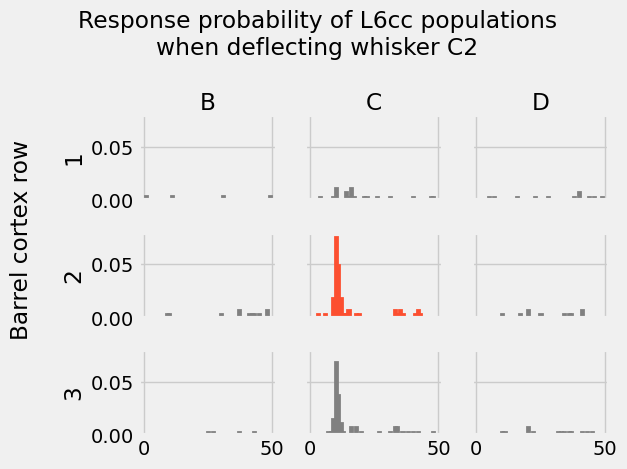

In [28]:
ct = "L6cc"
fig, axs = activity_gridplot(ct)
I.plt.show()

Note again that this time we are not visualizing the response probability of some neuron population to different inputs (like the first histogram grid). We are instead visualizing the response probabilities of different neuron populations to the same experimental condition: deflecting whisker C2.

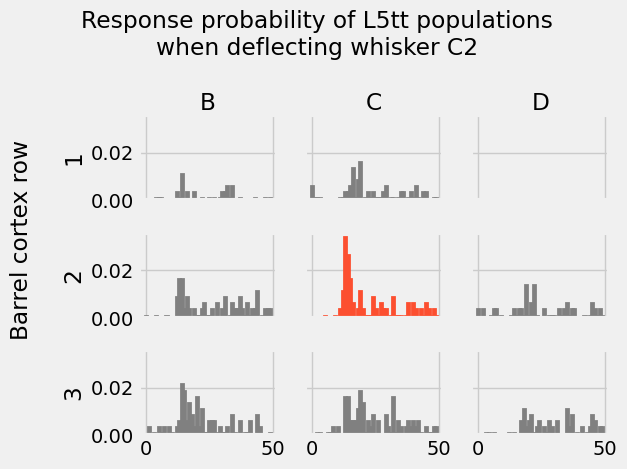

In [26]:
ct = "L5tt"
fig, axs = activity_gridplot(ct)
I.plt.show()

## Recap

[Tutorial 2.1](./2.1%20Anatomical%20embedding.ipynb) covered how to embed a neuron model into a network reconstruction, taking into account the relevant morphological, cellular and network properties. This tutorial covered how to generate synaptic activity. We are now ready to combine our biophysically detailed neuron model with this network model: see [Tutorial 3.1](../3.%20multiscale%20models/3.1%20Multiscale%20modeling.ipynb).